In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import h5py

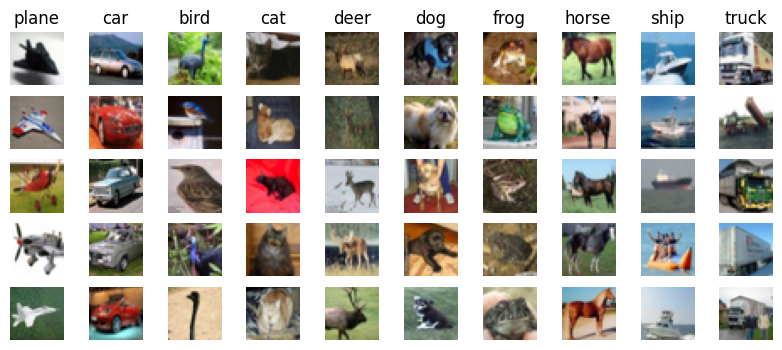

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
# itterate through the dataset until we find 5 images of each class and plot them
fig, axs = plt.subplots(5, 10, figsize=(10, 4))
axs = axs.ravel()
for i in range(10):
    idxs = np.where(train_labels[:] == i)
    idxs = idxs[0]
    for j in range(5):
        index = idxs[j]
        image = train_images[index]
        axs[10*j+i].axis('off')
        axs[10*j+i].imshow(image)
        if j == 0:
            axs[10*j+i].set_title(class_names[i])



In [10]:
class CNN(layers.Layer):
    def __init__(self, num_classes=10, train=False):
        super().__init__(trainable=train)
        self.pool = layers.MaxPooling2D((2, 2))
        self.flat = layers.Flatten()
        self.con1 = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))
        self.con2 = layers.Conv2D(64, (3, 3), activation='relu')
        self.con3 = layers.Conv2D(64, (3, 3), activation='relu')
        self.den1 = layers.Dense(64, activation='relu')
        self.den2 = layers.Dense(num_classes)
    def call(self, inputs):
        x = self.con1(inputs)
        x = self.pool(x)
        x = self.con2(x)
        x = self.pool(x)
        x = self.con3(x)
        x = self.flat(x)
        x = self.den1(x)
        return self.den2(x)

# create an instance of the CNN, pass some empty data through it, and log the weights
cnn = CNN()
cnn(tf.zeros([1, 32, 32, 3]))
for w in cnn.layers[0].get_weights():
    print(w.shape)


AttributeError: 'CNN' object has no attribute 'layers'

should be able to instantiate the CNN, get the weights, and use that to construct a hypercalculator

In [ ]:

class Add_One_to_Weights(models.Model):
    def __init__(self, w_init):
        super().__init__()
        self.conv = CNN()
        self.conv(tf.zeros((1, 32, 32, 3)))
        self.w = []
        for weight in self.conv.non_trainable_variables:
            self.w.append(tf.Variable(tf.add(weight,1)))
    def call(self, inputs):
        for somevar in range(len(self.w)):
            self.conv.non_trainable_variables[somevar].assign(self.w[somevar])
        x = self.conv(inputs)
        return x

class Reference_Model(models.Model):
    def __init__(self):
        super().__init__()
        self.conv = CNN(train=True)
    def call(self, inputs):
        x = self.conv(inputs)
        return x


Model: "reference__model_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_186 (CNN)               multiple                  122570    
                                                                 
Total params: 122,570
Trainable params: 122,570
Non-trainable params: 0
_________________________________________________________________
Model: "add__one_to__weights_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_187 (CNN)               multiple                  122570    
                                                                 
Total params: 245,140
Trainable params: 122,570
Non-trainable params: 122,570
_________________________________________________________________


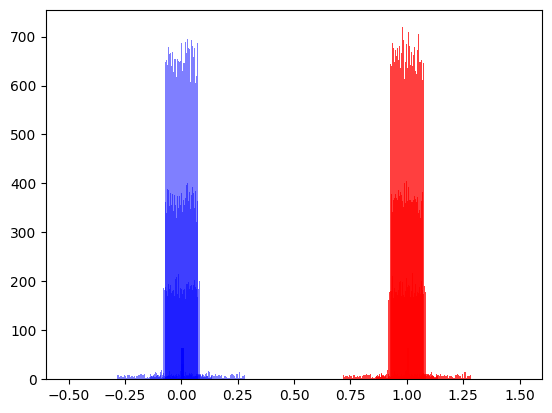

In [225]:
normal_model = Reference_Model()
normal_model(tf.zeros([1, 32, 32, 3]))
normal_model.summary()

weird_model = Add_One_to_Weights(normal_model.get_weights())
weird_model(tf.zeros([1, 32, 32, 3]))
weird_model.summary()

# print histograms for the distribution of parameter values in the two models
plt.figure()
for i in range(len(weird_model.w)):
    plt.hist(weird_model.w[i].numpy().ravel(), bins=100, alpha=0.5, color='red')
    plt.hist(normal_model.get_weights()[i].ravel(), bins=100, alpha=0.5, color='blue')
    plt.hist(weird_model.non_trainable_variables[i].numpy().ravel(), bins=100, alpha=0.5, color='red')

plt.show()

In [226]:
test_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# test gradient tape on the weird model
with tf.GradientTape() as tape:
    logits = weird_model(train_images[:1])
    loss_value = test_loss_fn(train_labels[:1], logits)
grads = tape.gradient(loss_value, weird_model.trainable_variables)
print(grads)

[None, None, None, None, None, None, None, None, None, None]


In [220]:
weird_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

weird_history = weird_model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

plt.plot(weird_history.history['accuracy'], label='accuracy')
plt.plot(weird_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = weird_model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

normal_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

normal_history = normal_model.fit(train_images, train_labels, epochs=10,
                        validation_data=(test_images, test_labels))

plt.plot(normal_history.history['accuracy'], label='accuracy')
plt.plot(normal_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = normal_model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

# print histograms for the distribution of parameter values in the two models
plt.figure()
for i in range(len(weird_model.w)):
    plt.hist(weird_model.w[i].numpy().ravel(), bins=100, alpha=0.5, color='red')
    plt.hist(normal_model.get_weights()[i].ravel(), bins=100, alpha=0.5, color='blue')

plt.show()

Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/engine/training.py", line 893, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 539, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 640, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=(3, 3, 3, 32) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(32,) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(3, 3, 32, 64) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(1024, 64) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(64, 10) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(10,) dtype=float32>)).


In [ ]:
# print histograms for the distribution of parameter values in the two models
plt.figure()
for i in range(len(weird_model.w)):
    plt.hist(weird_model.w[i].numpy().ravel(), bins=100, alpha=0.5, color='red')
    plt.hist(normal_model.get_weights()[i].ravel(), bins=100, alpha=0.5, color='blue')

plt.show()